#Import Library and Data Download

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=9ee25e9bc16b62f7ded9c450e49dc4c908edb9c6dcdb8fa19c439177a7c9609a
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip

--2021-04-15 08:31:07--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 64.233.188.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G  40.7MB/s    in 64s     

2021-04-15 08:32:12 (56.5 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
!mkdir train_local
!unzip nature_12K.zip -d train_local

Streaming output truncated to the last 5000 lines.
  inflating: train_local/inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3c

# **Data preprocessing and Augmentation**

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [ ]:
transform_horizontal = transforms.Compose([
    transforms.RandomResizedCrop(32),                                        
    transforms.RandomHorizontalFlip(),                                       
    transforms.ToTensor(),
    ])
transform_vertical = transforms.Compose([
     transforms.RandomResizedCrop(32),                                     
    transforms.RandomVerticalFlip(),                                       
    transforms.ToTensor(),
    ])
transform_Invert= transforms.Compose([
    transforms.RandomResizedCrop(32),                                  
    transforms.RandomInvert(),                                       
    transforms.ToTensor(),
    ])

In [ ]:
image_datasets = torchvision.datasets.ImageFolder(root= "/content/train_local/inaturalist_12K/train",  transform=transform_train)

In [ ]:
image_datasets_horizontallyFlipped= torchvision.datasets.ImageFolder(root= "/content/train_local/inaturalist_12K/train",  transform=transform_horizontal)
image_datasets_VerticallyFlipped= torchvision.datasets.ImageFolder(root= "/content/train_local/inaturalist_12K/train",  transform=transform_vertical)
image_datasets_Inverted= torchvision.datasets.ImageFolder(root= "/content/train_local/inaturalist_12K/train",  transform=transform_Invert)
image_datasets = image_datasets + image_datasets_Inverted + image_datasets_VerticallyFlipped + image_datasets_horizontallyFlipped

In [ ]:
classes = ('Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia')

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [ ]:
def train_val_dataset(dataset, val_split=0.1):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [ ]:
image_datasets = train_val_dataset(image_datasets)


In [ ]:
X_train=image_datasets['train']
X_Valid=image_datasets['val']

In [ ]:
trainloader = torch.utils.data.DataLoader(X_train, batch_size=128, shuffle=True)
validationloader = torch.utils.data.DataLoader(X_Valid, batch_size=128, shuffle=False)

In [ ]:
dataiter = iter(trainloader)
images_test, labels_test = dataiter.next()

print(images_test.shape)

print(images_test[1].shape)
print(labels_test[1].item())

torch.Size([128, 3, 32, 32])
torch.Size([3, 32, 32])
6


In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


#**Our CNN class**

In [ ]:
class I_Nature_v1(nn.Module):
    def __init__(self,batch_norm,k,file_org,F,d,act_fun):

        #self.input_dim=input
        #self.output_dim=output
        #self.k=k
        #self.F=F
        #self.file_org=file_org
        #self.act_fun=act_fun
        super(I_Nature_v1, self).__init__()
        
        self.cnn_model1 = nn.Sequential(
           nn.Conv2d(3,k,F), #(N,3,800,800)-->(N,16,798,798)
           act_fun,
      
           
           nn.MaxPool2d(2,stride=1),  #(2,2) filter(1st param)  (N,16,798,798)-->(N,16,798,798)
           nn.Conv2d(k,int(k*file_org),F), #(N,16,798,798)-->(N,16,796,796),
          
           act_fun,
           nn.MaxPool2d(2,stride=1), #(N,16,796,796)->(N,16,398,398),
         
           nn.Conv2d(int(k*file_org),int(k*(file_org**2)),F), #(N,16,398,398)-->(N,16,396,396),
        
           act_fun,
           nn.MaxPool2d(2,stride=1), #(N,16,396,396)->(N,16,198,198),
          
#Add 2 Layers
           
           nn.Conv2d(int(k*(file_org**2)),int(k*(file_org**3)),F),    #(N,16,198,198)-->(N,16,196,196),
           #input_dim=output_dim,
           #output_dim=input_dim-self.F+1,
           #self.k=self.k*Self.file_org,
           act_fun,
           nn.MaxPool2d(2,stride=2), #(N,16,196,196)->(N,16,98,98)
           #output_dim=output_dim/2,
           nn.Conv2d(int(k*(file_org**3)),int(k*(file_org**4)),int(F)), #(N,16,98,98)-->(N,6,96,96),
           #input_dim=output_dim,
           #output_dim=input_dim-self.F+1,
           act_fun,
           nn.MaxPool2d(2,stride=2), #(N,6,96,96)->(N,6,24,24)
           #output_dim=output_dim/4
        )




        self.cnn_model2 = nn.Sequential(
           nn.Conv2d(3,k,F), #(N,3,800,800)-->(N,16,798,798)
           nn.BatchNorm2d(int(k)),
           #nn.BatchNorm2d(k),
           act_fun,
      
           
           nn.MaxPool2d(2,stride=1),  #(2,2) filter(1st param)  (N,16,798,798)-->(N,16,798,798)
           nn.Conv2d(k,int(k*file_org),F), #(N,16,798,798)-->(N,16,796,796),
           nn.BatchNorm2d(int(k*(file_org**1))),
           
           act_fun,
           nn.MaxPool2d(2,stride=1), #(N,16,796,796)->(N,16,398,398),
         
           nn.Conv2d(int(k*file_org),int(k*(file_org**2)),F), #(N,16,398,398)-->(N,16,396,396),
           nn.BatchNorm2d(int(k*(file_org**2))),
           act_fun,
           nn.MaxPool2d(2,stride=1), #(N,16,396,396)->(N,16,198,198),
          
#Add 2 Layers
           
           nn.Conv2d(int(k*(file_org**2)),int(k*(file_org**3)),F),    #(N,16,198,198)-->(N,16,196,196),
           nn.BatchNorm2d(int(k*(file_org**3))),
           #input_dim=output_dim,
           #output_dim=input_dim-self.F+1,
           #self.k=self.k*Self.file_org,
           act_fun,
           nn.MaxPool2d(2,stride=2), #(N,16,196,196)->(N,16,98,98)
           #output_dim=output_dim/2,
           nn.Conv2d(int(k*(file_org**3)),int(k*(file_org**4)),int(F)), #(N,16,98,98)-->(N,6,96,96),
           nn.BatchNorm2d(int(k*(file_org**4))),
           #input_dim=output_dim,
           #output_dim=input_dim-self.F+1,
           act_fun,
           nn.MaxPool2d(2,stride=2), #(N,6,96,96)->(N,6,24,24)
           #output_dim=output_dim/4
        )


        input_dim=32
        output_dim=input_dim-F+1  #conv1_outpu
        input_dim=output_dim-2   #Max_pool_layer_1
        output_dim=input_dim-F+1  #conv2_outpu
        output_dim=output_dim-1 #Max_pool_layer_2
        input_dim=output_dim
        output_dim=input_dim-F+1 #conv3_outpu
        output_dim=output_dim-1  #Max_pool_layer_3
        input_dim=output_dim
        output_dim=input_dim-F+1 #conv4_outpu
        output_dim=int(output_dim/2) #Max_pool_layer_4
        
        input_dim=output_dim
        print(output_dim)#4
        output_dim=input_dim-F+1  #conv5_outpu
        print(output_dim)#2
        output_dim=output_dim/2 #Max_pool_layer_5
        output_dim=int(output_dim)
        print(output_dim)



        self.fc_model = nn.Sequential(
           nn.Linear(int(output_dim*output_dim*k*(file_org**4)),120),
           nn.ReLU(),
           nn.Dropout(d),
           nn.Linear(120,10)
        )





    def forward(self, x,batch_norm):
        if (batch_norm==0):
          x = self.cnn_model1(x)
        else:
          x = self.cnn_model2(x)
          
       
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_model(x)
        #print(x.shape)
        return x
    

      


In [ ]:
def Evaluation(dataloader,model,batch_norm):
  total,correct=0,0
  for data in dataloader:
    inputs,labels=data
    inputs,labels=inputs.to(device),labels.to(device)
    outputs=model(inputs,batch_norm)
    _,pred=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(pred==labels).sum().item()
  return 100*correct/total





In [ ]:
import copy
import torch.optim as optim

#**Fit Function for Training Model**

In [ ]:
    def fit(model_t,batch_norm,k,file_org,F,max_epochs,batch_size,d,act_fun=nn.ReLU()):
 #self.Model_tree()
      loss_epoch_arr=[]
      loss_valid_epoch_arr=[]
      min_loss=1000
      #max_epochs=10
      net=model_t
      n_iter=np.ceil(8999/batch_size)
      
      for epoch in range(max_epochs):
        #opt = optim.Adam(net.parameters())
        #print(type(opt))
        #print("hi hjj")
        for i,data in enumerate(trainloader,0):

          inputs,labels=data
          inputs,labels=inputs.to(device),labels.to(device)
          opt.zero_grad()
          outputs=net(inputs,batch_norm) #forwrd_pass
          loss=loss_fn(outputs,labels)
          loss.backward()
          opt.step() #Update the parameter after the backward paas using opt optimiser
          if(min_loss>loss.item()):  #change by LG
            min_loss=loss.item()
            best_model=copy.deepcopy(net.state_dict())
            print("Min Loss is %.2f" % min_loss)
      
      
          del inputs,labels,outputs
          torch.cuda.empty_cache()
      
          if(i%100==0):
            print("Iteration : %d/%d , Loss: %0.2f " %(i,n_iter,loss.item()))
      
      
      
        #for i,data1 in enumerate(validationloader,0):
          #inputs_Val,labels_Val=data1
          #inputs_Val,labels_Val=inputs_Val.to(device),labels_Val.to(device)
          #outputs_val=net(inputs_Val,batch_norm) #forwrd_pass
          #loss_val=loss_fn(outputs_val,labels_Val)
          #del inputs_Val,labels_Val,outputs_val
          #torch.cuda.empty_cache()

         # loss_arr.append(loss.item())
        #loss_valid_epoch_arr.append(loss_val.item()) 
        loss_epoch_arr.append(loss.item())

       
       ##wandb.log({
        ##  "Epoch":epoch,
          #"Train Acc":accuracy_train,
          #"Train loss":loss_epoch_arr[epoch],
          #"validation loss":loss_valid_epoch_arr[epoch],
          #"Test Acc":accura
          #"Validation Acc":Evaluation(validationloader,net,batch_norm),
          #"layer_param":layer_param1

       # })"""
      
      
        #print("epoch: %d/%d,Train_acc:%.2f,Test_acc:%.2f" % (epoch,max_epochs,Evaluation(trainloader,net),Evaluation(testloader,net)))
      
      
      plt.plot(loss_epoch_arr)
      plt.show()

# **4.(a)Creating Best Model with our best parameters**

In [ ]:
batch_norm=1
k=128
file_org=1
F=3
d=0.0
act_fun=nn.ReLU()
max_epochs=20
batch_size=128
net = I_Nature_v1(batch_norm=batch_norm,k=k,file_org=file_org,F=F,d=d,act_fun=act_fun).to(device)
model_t=net
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

10
8
4


Min Loss is 1.85
Iteration : 0/71 , Loss: 1.85 
Min Loss is 1.82
Min Loss is 1.69
Min Loss is 1.64
Min Loss is 1.62
Iteration : 0/71 , Loss: 1.83 
Min Loss is 1.60
Iteration : 0/71 , Loss: 1.85 
Iteration : 0/71 , Loss: 1.91 
Min Loss is 1.58
Min Loss is 1.56
Iteration : 0/71 , Loss: 1.76 
Min Loss is 1.55
Iteration : 0/71 , Loss: 1.74 
Iteration : 0/71 , Loss: 1.81 
Min Loss is 1.54
Iteration : 0/71 , Loss: 1.67 
Iteration : 0/71 , Loss: 1.80 
Min Loss is 1.53
Iteration : 0/71 , Loss: 1.74 
Iteration : 0/71 , Loss: 1.64 
Min Loss is 1.52
Iteration : 0/71 , Loss: 1.63 
Iteration : 0/71 , Loss: 1.70 
Iteration : 0/71 , Loss: 1.59 
Iteration : 0/71 , Loss: 1.58 
Iteration : 0/71 , Loss: 1.66 
Min Loss is 1.40
Iteration : 0/71 , Loss: 1.82 
Iteration : 0/71 , Loss: 1.67 
Iteration : 0/71 , Loss: 1.65 
Min Loss is 1.38
Iteration : 0/71 , Loss: 1.77 


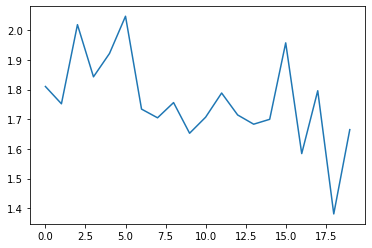

In [ ]:
fit(model_t,batch_norm,k,file_org,F,max_epochs,batch_size,d,act_fun=nn.ReLU())

In [ ]:
print("Train_accuracy:%.2f" % (Evaluation(trainloader,model_t,batch_norm)))

Train_accuracy:42.20


In [ ]:
print("Validation_accuracy:%.2f" % (Evaluation(validationloader,model_t,batch_norm)))

Validation_accuracy:35.60


# **checking Accuracy for Test Data**
**First Time loading and using test Data**

In [ ]:
test_data= torchvision.datasets.ImageFolder(root= "/content/train_local/inaturalist_12K/val",  transform=transform_test)

In [ ]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

In [ ]:
print("Test_accuracy:%.2f" % (Evaluation(testloader,model_t,batch_norm)))

Test_accuracy:37.95


#**Question4(c)**

In [ ]:
model_t = model_t.to('cpu')

In [ ]:
out_test = model_t(images_test,batch_norm)
#print(out.shape)

In [ ]:
out_test = net.cnn_model2[0](images_test)
out_test.shape

torch.Size([128, 128, 30, 30])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


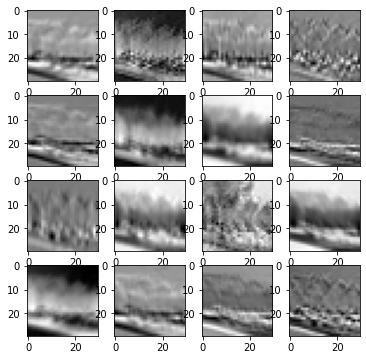

In [ ]:
plt.figure(figsize = (6,6))
plt.subplot(441)
image_id = 0
for i in range(16):
    ax1 = plt.subplot(4, 4, i+1)
    plt.imshow(out_test[image_id, i, :, :].detach().numpy(), cmap="binary")
    #image_id+=1
plt.show()


#**Question4(b)**

In [ ]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=30, shuffle=True)

In [ ]:
dataiter = iter(testloader)
images_test_c, labels_test_c = dataiter.next()
#print(images_test_c.shape)
#print(images_test_c[2].shape)
#print(labels_test_c[2].item())

In [ ]:
out_test_c = model_t(images_test_c,batch_norm)
#print(out_test_c.shape)

In [ ]:
imag=images_test_c[0].unsqueeze(0)
#print(imag)



In [ ]:
out_test_c = model_t(imag,batch_norm)
#print(out_test_c.shape)

In [ ]:
npimg = np.transpose(images_test_c[0], (1, 2, 0))
#print(npimg.shape)

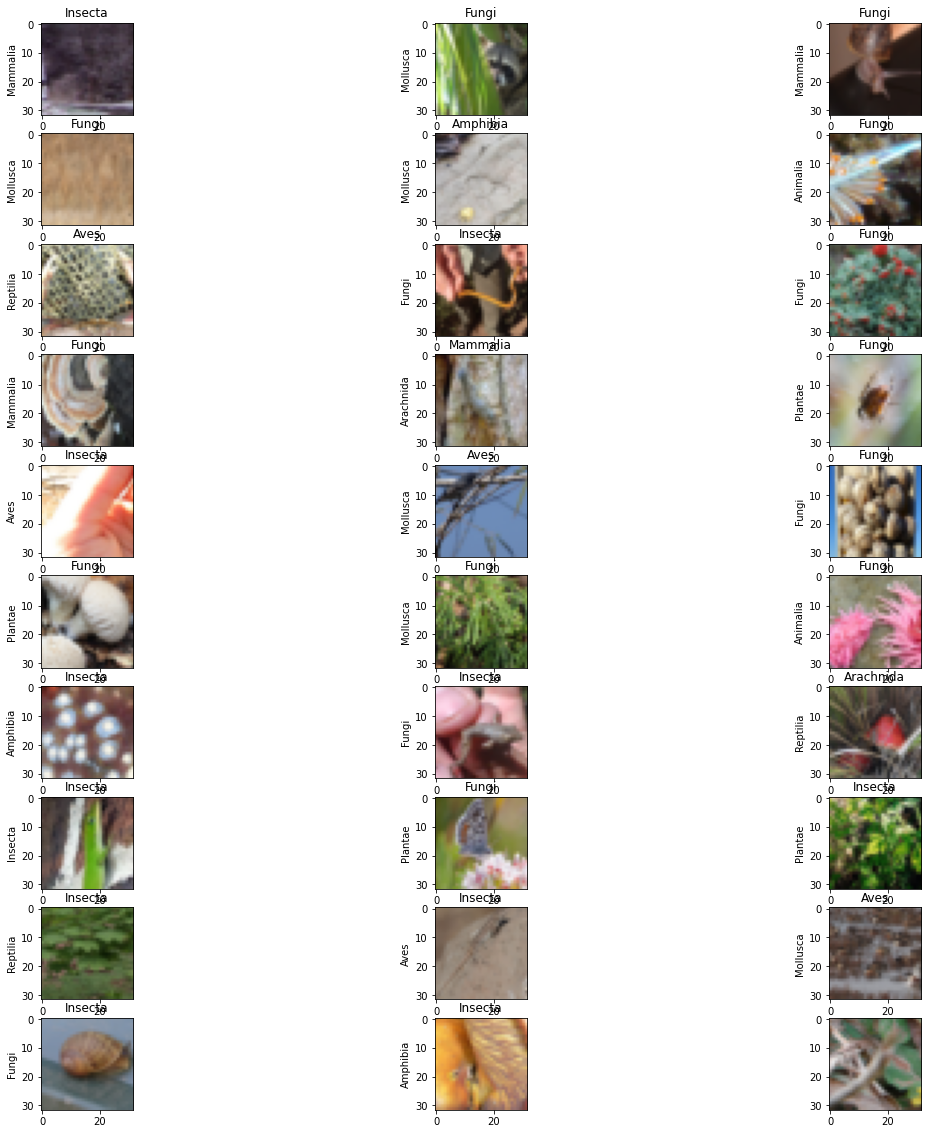

In [ ]:
plt.figure(figsize = (20,20))
plt.subplot(321)
for i in range(30):
  imag=images_test_c[i].unsqueeze(0)
  out_test_c = model_t(imag,batch_norm) # Apply Forward propogation to already trained model.h
  plt.title(classes[out_test_c.argmax(dim=1).item()])
  plt.ylabel((classes[labels_test_c[i].item()]))
  #print((classes[i]))
  npimg = np.transpose(images_test_c[i], (1, 2, 0))
  ax1 = plt.subplot(10, 3, i+1)
 # print((classes[labels_test_c[i].item()]))
  plt.imshow(npimg/2 +0.5)
  #print(out_test_c.shape)
  #print(imag)